In [1]:
import os
import itertools
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import PIPE
from concurrent.futures import ProcessPoolExecutor, as_completed
from time import sleep
from tqdm import tqdm

sns.set_style("whitegrid")

In [9]:
def run_subprocess(i, arg, script, parameter):
    complete = subprocess.run([".venv/bin/python", script] + arg, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return {
        'runIdx': i,
        'stdout': complete.stdout,
        'stderr': complete.stderr,
        'exit_code': complete.returncode,
        'params': parameter
    }

In [10]:
def runTraining(script, params, runs, max_workers=None, parallel=True):

    permutations_dicts = [
        dict(zip(params.keys(), values))
        for values in itertools.product(
            *(value if isinstance(value, list) else [value] for value in params.values())
        )
    ]
    
    parameter_list = permutations_dicts * runs
        
    args = [
        [
            "--epochs", str(param["epochs"]),
            "--number-of-clauses", str(param["number-of-clauses"]),
            "--T", str(param["T"]),
            "--s", str(param["s"]),
            "--depth", str(param["depth"]),
            "--hypervector-size", str(param["hypervector-size"]),
            "--hypervector-bits", str(param["hypervector-bits"]),
            "--message-size", str(param["message-size"]),
            "--message-bits", str(param["message-bits"]),
        ]
        for param in parameter_list
    ]

    results = []

    if parallel:
        cpu_count = os.cpu_count()
        max_workers = max_workers or cpu_count
        
        # GPU limted, no real performance gained with parallel training
        with ProcessPoolExecutor(max_workers=max_workers) as executor:
            futures = {
                executor.submit(run_subprocess, i, arg, script, parameter_list[i]): i
                for i, arg in enumerate(args)
            }
            
            for future in tqdm(as_completed(futures), total=len(futures), desc="Training models:"):
                results.append(future.result())
    else:
        for i, arg in enumerate(tqdm(args, desc="Training models sequentially")):
            result = run_subprocess(i, arg, script, parameter_list[i])
            results.append(result)
    
    return results

In [11]:
def getResultsAsDataframe(results):

    parsed = []
    for result in tqdm(results, total=len(results), desc="Building results"):
        lines = result['stdout'].splitlines()

        if len(lines) < 3:
                raise ValueError("Unexpected stdout format.")

        epoch_progress = [float(i) for i in lines[1].split()]
        avg_accuracy, max_accuracy, max_epoch = [float(i) for i in lines[2].split()]

        params = result['params']
        result_without_params = {k: v for k, v in result.items() if k != 'params'}

        parsed.extend([
                {
                    **result_without_params,
                    'avg_accuracy': avg_accuracy,
                    'max_accuracy': max_accuracy,
                    'max_epoch': max_epoch,
                    'epoch_progress': epoch,
                    'epoch_number': i,
                    **params
                }
                for i, epoch in enumerate(epoch_progress)
            ])

    return pd.DataFrame(parsed)

In [12]:
params = {
    'epochs': 80,
    'number-of-clauses': [18,500,1000,2000],
    'T': 400,
    's': 0.8,
    'depth': 3,
    'hypervector-size': 512,
    'hypervector-bits': 2,
    'message-size': 512,
    'message-bits': 2,
}
runs = 2

training_results = runTraining("3x3_stdout_.py", params, runs, parallel=False)

Training models sequentially: 100%|██████████| 8/8 [19:17<00:00, 144.63s/it]


In [13]:
results = getResultsAsDataframe(training_results)

Building results: 100%|██████████| 8/8 [00:00<00:00, 10248.76it/s]


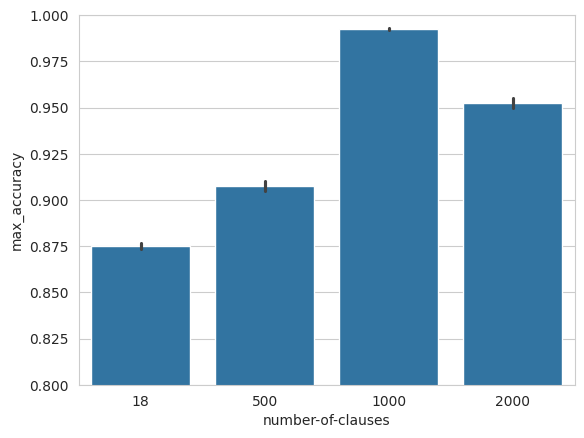

In [20]:
sns.barplot(data=results,
            x='number-of-clauses',
            y='max_accuracy')
plt.ylim([0.8,1])
plt.show()

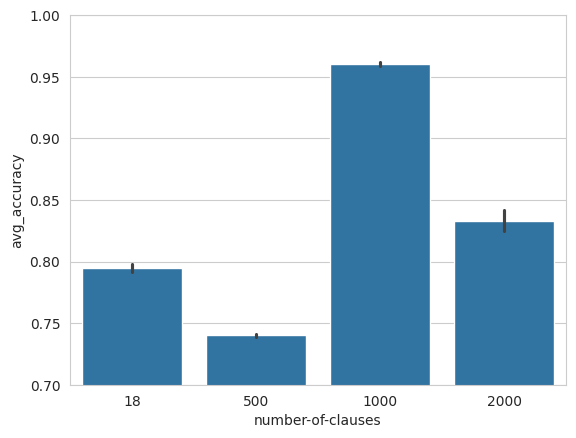

In [21]:
sns.barplot(data=results,
            x='number-of-clauses',
            y='avg_accuracy')
plt.ylim([0.7,1])
plt.show()

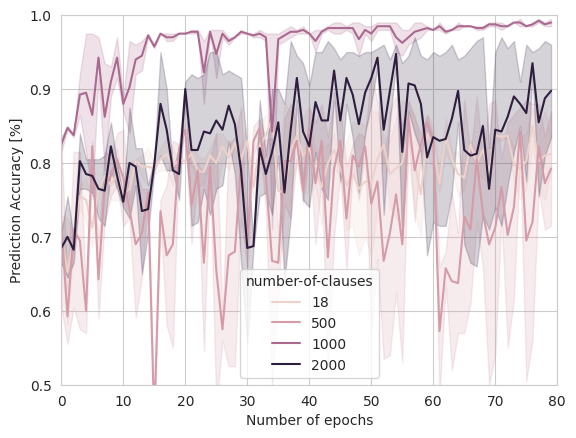

In [22]:
sns.lineplot(data=results,
             x='epoch_number',
             y='epoch_progress',
             hue='number-of-clauses')
plt.xlabel('Number of epochs')
plt.ylabel('Prediction Accuracy [%]')
plt.xlim([0,80])
plt.ylim([0.5,1])
plt.show()